In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
device = 'cuda:0'

In [2]:
import random
import numpy as np
from scipy.spatial.distance import directed_hausdorff, jensenshannon
from scipy.stats import wasserstein_distance
import time
import torch
import torch.nn as nn
import torch.optim as optim
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore

In [4]:
def sample_inhomogeneous_poisson(lambda_max, lambda_func, T):
    """
    Samples from an inhomogeneous Poisson process.

    Parameters:
    - lambda_max: Maximum value of the intensity function (over the interval [0, T]).
    - lambda_func: Intensity function λ(t), should take a single argument t and return λ(t).
    - T: End time of the process.

    Returns:
    - times: Array of event times.
    """
    # Step 1: Sample from a homogeneous Poisson process with rate lambda_max
    n_samples = np.random.poisson(lambda_max * T)
    uniform_times = np.random.uniform(0, T, size=n_samples)
    uniform_times.sort()  # Sort times to maintain temporal order
    
    # Step 2: Thinning step
    acceptance_probabilities = lambda_func(uniform_times) / lambda_max
    accepted = np.random.uniform(0, 1, size=n_samples) < acceptance_probabilities
    times = uniform_times[accepted]
    
    return times




In [5]:
def rate_function2_freeT(t, t1, rate1, rate2, N):
    r1 = N*rate1
    r2 = N*rate2
    # print(t_)
    r = np.zeros_like(t)
    r[t<t1] = r1
    r[t>=t1] = r2
    return r

In [6]:
def cdf_inv(y, rate):
    if rate == 1:
        return y
    ans = np.zeros(y.shape)
    x_ = (rate - 1) / (rate - 1/rate)
    y_ = x_ / rate
    ans[y<y_] = y[y<y_] * rate
    ans[y>=y_] = x_ + (y[y>=y_] - y_) / rate
    return ans

In [7]:
def JS_div(data1, data2, bins=10, eps=1e-5, return_binwise_values=False):
    x_min = min(np.min(data1), np.min(data2)) - eps
    x_max = max(np.max(data1), np.max(data2)) + eps
    h1, bin_edges = np.histogram(data1, bins=bins, range=(x_min, x_max))
    h2, bin_edges = np.histogram(data2, bins=bins, range=(x_min, x_max))
    p1 = h1/len(data1)
    p2 = h2/len(data2)
    if return_binwise_values:
        m = 0.5*(p1+p2)
        binwise_values = np.zeros_like(m)
        binwise_values[p1>0] += 0.5 * p1[p1>0] * np.log(p1[p1>0]/m[p1>0])
        binwise_values[p2>0] += 0.5 * p2[p2>0] * np.log(p2[p2>0]/m[p2>0])
        return jensenshannon(p1, p2)**2, binwise_values, p1, p2
    return jensenshannon(p1, p2)**2

def hausdorff_distance_np(arr1, arr2, return_values=False):
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    distances = np.abs(arr1[:, None] - arr2[None, :])
    forward = np.max(np.min(distances, axis=1))
    backward = np.max(np.min(distances, axis=0))
    if return_values:
        return max(forward, backward), np.array([forward, backward])
    return max(forward, backward)

In [8]:
def get_wasserstein_features(data1, data2, bins):
    data1_repeated = np.repeat(data1, len(data2))
    data2_repeated = np.repeat(data2, len(data1))
    indices = np.round(np.linspace(0, len(data1)*len(data2), bins + 1))
    return np.array([np.abs(data1_repeated - data2_repeated)[int(indices[i]):int(indices[i+1])].mean() for i in range(bins)])

def sample_random_processes2_freeT(Ndata, N, max_offset, max_rate, bins):
    rate1_list = np.random.rand(Ndata) * max_rate * 2 - max_rate
    rate2_list = np.random.rand(Ndata) * max_rate * 2 - max_rate
    # rate2_list[rate1_list>0] *= -1
    t1_list = []
    t2_list = []
    offset_list = np.random.rand(Ndata) * max_offset * 2 - max_offset
    wass_list = np.zeros(Ndata)
    wass_feature_list = np.zeros((Ndata, bins))
    JS_list = np.zeros(Ndata)
    JS_feature_list = np.zeros((Ndata, bins))
    haus_list = np.zeros(Ndata)
    haus_feature_list = np.zeros((Ndata, 2))
    sorted_data1_list = []
    sorted_data2_list = []
    min_len = N
    max_len = N

    for k in range(Ndata):
        # from inhomogeneous poisson
        rate1 = np.exp(rate1_list[k])
        rate2 = np.exp(rate2_list[k])
        offset = offset_list[k]
        # data1 = np.random.rand(N)
        # data2 = cdf_inv(np.random.rand(N), 1/rate) + offset
        # set t1 and t2
        t1 = 0.5/rate1
        t2 = 0.5/rate2
        t1_list.append(t1)
        t2_list.append(t2)
        T = t1 + t2
        data1 = sample_inhomogeneous_poisson(N, lambda t: rate_function2_freeT(t, 1, 1, 1, N), 1)
        data2 = sample_inhomogeneous_poisson(max(rate1, rate2)*N, lambda t: rate_function2_freeT(t, t1, rate1, rate2, N), T) + offset
        
        haus_list[k], haus_feature_list[k] = hausdorff_distance_np(data1, data2, return_values=True)
        #print(time.time() - start_time)
        wass_list[k] = wasserstein_distance(data1, data2)
        #print(time.time() - start_time)
        wass_feature_list[k] = get_wasserstein_features(data1, data2, bins)
        JS_list[k], JS_feature_list[k], _, _ = JS_div(data1, data2, bins, return_binwise_values=True)
        #print(time.time() - start_time)
        sorted_data1_list.append(np.sort(data1))
        sorted_data2_list.append(np.sort(data2))
        if len(data1) < min_len:
            min_len = len(data1)
        if len(data2) < min_len:
            min_len = len(data2)
        if len(data1) > max_len:
            max_len = len(data1)
        if len(data2) > max_len:
            max_len = len(data2)
            
    sorted_data1_arr = np.asarray(sorted_data1_list, dtype=object)
    sorted_data2_arr = np.asarray(sorted_data2_list, dtype=object)
    print(min_len, max_len)
    
    data = {}
    data['Ndata'] = Ndata
    data['N'] = N
    data['max_offset'] = max_offset
    data['max_rate'] = max_rate
    data['bins'] = bins
    data['rate1_list'] = rate1_list
    data['rate2_list'] = rate2_list
    data['t1_list'] = np.array(t1_list)
    data['t2_list'] = np.array(t2_list)
    data['offset_list'] = offset_list
    data['wass_list'] = wass_list
    data['wass_feature_list'] = wass_feature_list
    data['JS_list'] = JS_list
    data['JS_feature_list'] = JS_feature_list
    data['haus_list'] = haus_list
    data['haus_feature_list'] = haus_feature_list
    data['sorted_data1_arr'] = sorted_data1_arr
    data['sorted_data2_arr'] = sorted_data2_arr
    data['min_len'] = min_len
    data['max_len'] = max_len
    return data

In [9]:
seed_everything(1)

In [10]:
Ndata = 10000
N = 100
max_offset = 2
max_rate = 2
bins = 10
data = sample_random_processes2_freeT(Ndata, N, max_offset, max_rate, bins)
# data

63 144


In [11]:
testdata = sample_random_processes2_freeT(Ndata, N, max_offset, max_rate, bins)

63 154


In [12]:
X_wass = data['wass_feature_list']
X_JS = data['JS_feature_list']
X_haus = data['haus_feature_list']
y_train_np = np.concatenate([data['rate1_list'], data['rate2_list'], data['offset_list']]).reshape(3,-1).T
y_train_np2 = np.concatenate([data['rate1_list'], data['rate2_list'], np.abs(data['offset_list'])]).reshape(3,-1).T

In [13]:
X_wass_test = testdata['wass_feature_list']
X_JS_test = testdata['JS_feature_list']
X_haus_test = testdata['haus_feature_list']
y_test_np = np.concatenate([testdata['rate1_list'], testdata['rate2_list'], testdata['offset_list']]).reshape(3,-1).T
y_test_np2 = np.concatenate([testdata['rate1_list'], testdata['rate2_list'], np.abs(testdata['offset_list'])]).reshape(3,-1).T

In [14]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, hidden_layers=2):
        super(MLP, self).__init__()
        layerlist = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for i in range(hidden_layers-1):
            layerlist.append(nn.Linear(hidden_dim, hidden_dim))
            layerlist.append(nn.ReLU())
        layerlist.append(nn.Linear(hidden_dim, output_dim))
        
        self.model = nn.Sequential(*layerlist)
    
    def forward(self, x):
        return self.model(x)

def trainMLP(X_train, y_train, X_test, y_test, n_epochs = 100, batch_size = 32, hidden_layers=2, lr=0.001):
    
    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    
    # Initialize the model, loss function, and optimizer
    input_dim = X_train.shape[1]
    hidden_dim = 64
    output_dim = y_train.shape[1]
    
    model = MLP(input_dim, hidden_dim, output_dim, hidden_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_traj = []
    testloss_traj = []
    
    # Training loop
    for epoch in range(n_epochs):
        model.train()
        permutation = torch.randperm(X_train.size(0))
        N, curloss = 0, 0
        curloss_vec = np.zeros(output_dim)
        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_X, batch_y = X_train[indices].to(device), y_train[indices].to(device)
    
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
    
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            N += len(batch_X)
            curloss += loss.item()*len(batch_X)*output_dim
            temp = ((outputs - batch_y)**2).sum(dim=0)
            for j in range(output_dim):
                curloss_vec[j] += temp[j].item()
        loss_traj.append(curloss_vec / N)
        
        # Print progress
        if (epoch + 1) % 100 == 0:
            tempstr = ''
            for j in range(output_dim):
                tempstr += f', Loss{j}: {curloss_vec[j]/N:.4f}'
            print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {curloss/N:.4f}"+tempstr)
    
        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test.to(device))
            N = len(X_test)
            test_loss = criterion(y_pred, y_test.to(device))*output_dim
            
            temp = ((y_pred - y_test.to(device))**2).sum(dim=0) 
            testloss_traj.append(temp.cpu().numpy()/N)
            if epoch == n_epochs - 1:
                tempstr = ''
                for j in range(output_dim):
                    tempstr += f', Test Loss{j}: {temp[j].item()/N:.4f}'
                print(f"Test Loss: {test_loss.item():.4f}" + tempstr)
            
    loss_traj, testloss_traj = np.array(loss_traj), np.array(testloss_traj)
    return model, loss_traj, testloss_traj

In [15]:
X_train = data['wass_feature_list']
X_test = testdata['wass_feature_list']
y_train = y_train_np2
y_test = y_test_np2

model_w_torch, loss_w_traj, testloss_w_traj =  trainMLP(X_train, y_train, X_test, y_test, n_epochs = 10000, batch_size = 10000)

Epoch [100/10000], Loss: 1.5663, Loss0: 0.8158, Loss1: 0.7225, Loss2: 0.0280
Epoch [200/10000], Loss: 1.1618, Loss0: 0.5838, Loss1: 0.5661, Loss2: 0.0119
Epoch [300/10000], Loss: 1.0406, Loss0: 0.5240, Loss1: 0.5095, Loss2: 0.0071
Epoch [400/10000], Loss: 0.9570, Loss0: 0.4839, Loss1: 0.4672, Loss2: 0.0059
Epoch [500/10000], Loss: 0.8912, Loss0: 0.4540, Loss1: 0.4317, Loss2: 0.0054
Epoch [600/10000], Loss: 0.8432, Loss0: 0.4348, Loss1: 0.4030, Loss2: 0.0053
Epoch [700/10000], Loss: 0.7958, Loss0: 0.4155, Loss1: 0.3752, Loss2: 0.0051
Epoch [800/10000], Loss: 0.7541, Loss0: 0.3981, Loss1: 0.3510, Loss2: 0.0050
Epoch [900/10000], Loss: 0.7089, Loss0: 0.3739, Loss1: 0.3301, Loss2: 0.0049
Epoch [1000/10000], Loss: 0.6710, Loss0: 0.3537, Loss1: 0.3125, Loss2: 0.0048
Epoch [1100/10000], Loss: 0.6400, Loss0: 0.3359, Loss1: 0.2993, Loss2: 0.0048
Epoch [1200/10000], Loss: 0.6157, Loss0: 0.3211, Loss1: 0.2898, Loss2: 0.0048
Epoch [1300/10000], Loss: 0.5960, Loss0: 0.3097, Loss1: 0.2814, Loss2: 0.

In [16]:
X_train = X_JS
X_test = X_JS_test
y_train = y_train_np2
y_test = y_test_np2

model_JS_torch, loss_JS_traj, testloss_JS_traj =  trainMLP(X_train, y_train, X_test, y_test, n_epochs = 10000, batch_size = 10000)

Epoch [100/10000], Loss: 2.8724, Loss0: 1.2622, Loss1: 1.3172, Loss2: 0.2931
Epoch [200/10000], Loss: 2.2839, Loss0: 1.0315, Loss1: 0.9968, Loss2: 0.2557
Epoch [300/10000], Loss: 1.8352, Loss0: 0.9362, Loss1: 0.6933, Loss2: 0.2057
Epoch [400/10000], Loss: 1.6828, Loss0: 0.8354, Loss1: 0.6650, Loss2: 0.1823
Epoch [500/10000], Loss: 1.5776, Loss0: 0.7637, Loss1: 0.6414, Loss2: 0.1725
Epoch [600/10000], Loss: 1.5031, Loss0: 0.7273, Loss1: 0.6068, Loss2: 0.1691
Epoch [700/10000], Loss: 1.4551, Loss0: 0.7012, Loss1: 0.5870, Loss2: 0.1669
Epoch [800/10000], Loss: 1.4207, Loss0: 0.6778, Loss1: 0.5790, Loss2: 0.1639
Epoch [900/10000], Loss: 1.3891, Loss0: 0.6565, Loss1: 0.5719, Loss2: 0.1607
Epoch [1000/10000], Loss: 1.3533, Loss0: 0.6359, Loss1: 0.5608, Loss2: 0.1566
Epoch [1100/10000], Loss: 1.3182, Loss0: 0.6176, Loss1: 0.5483, Loss2: 0.1523
Epoch [1200/10000], Loss: 1.2915, Loss0: 0.6040, Loss1: 0.5388, Loss2: 0.1486
Epoch [1300/10000], Loss: 1.2688, Loss0: 0.5917, Loss1: 0.5316, Loss2: 0.

In [17]:
X_train = X_haus
X_test = X_haus_test
y_train = y_train_np2
y_test = y_test_np2

model_haus_torch, loss_haus_traj, testloss_haus_traj =  trainMLP(X_train, y_train, X_test, y_test, n_epochs = 10000, batch_size = 10000)

Epoch [100/10000], Loss: 1.6786, Loss0: 0.7567, Loss1: 0.7678, Loss2: 0.1541
Epoch [200/10000], Loss: 1.6116, Loss0: 0.7375, Loss1: 0.7530, Loss2: 0.1211
Epoch [300/10000], Loss: 1.6010, Loss0: 0.7326, Loss1: 0.7491, Loss2: 0.1193
Epoch [400/10000], Loss: 1.5868, Loss0: 0.7278, Loss1: 0.7436, Loss2: 0.1154
Epoch [500/10000], Loss: 1.5770, Loss0: 0.7250, Loss1: 0.7413, Loss2: 0.1107
Epoch [600/10000], Loss: 1.5718, Loss0: 0.7243, Loss1: 0.7400, Loss2: 0.1075
Epoch [700/10000], Loss: 1.5688, Loss0: 0.7241, Loss1: 0.7392, Loss2: 0.1055
Epoch [800/10000], Loss: 1.5668, Loss0: 0.7239, Loss1: 0.7385, Loss2: 0.1044
Epoch [900/10000], Loss: 1.5650, Loss0: 0.7237, Loss1: 0.7376, Loss2: 0.1037
Epoch [1000/10000], Loss: 1.5635, Loss0: 0.7235, Loss1: 0.7370, Loss2: 0.1030
Epoch [1100/10000], Loss: 1.5620, Loss0: 0.7233, Loss1: 0.7364, Loss2: 0.1023
Epoch [1200/10000], Loss: 1.5607, Loss0: 0.7231, Loss1: 0.7359, Loss2: 0.1018
Epoch [1300/10000], Loss: 1.5596, Loss0: 0.7229, Loss1: 0.7354, Loss2: 0.

In [18]:
X_train = data['wass_feature_list']
X_test = testdata['wass_feature_list']

y_pred_w = model_w_torch(torch.FloatTensor(X_test).to(device)).detach().cpu().numpy()

X_train = X_JS
X_test = X_JS_test

y_pred_JS = model_JS_torch(torch.FloatTensor(X_test).to(device)).detach().cpu().numpy()

X_train = X_haus
X_test = X_haus_test

y_pred_haus = model_haus_torch(torch.FloatTensor(X_test).to(device)).detach().cpu().numpy()

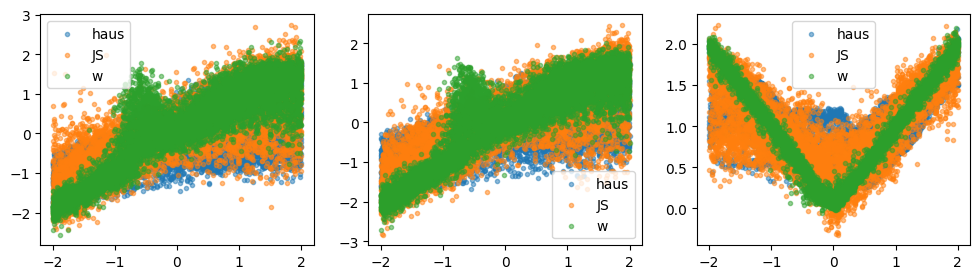

In [19]:
plt.figure(figsize=(12, 3))
for idx in range(3):
    plt.subplot(1,3,idx+1)
    # idx=0
    plt.scatter(y_test_np[:,idx], y_pred_haus[:,idx], marker='.', alpha=0.5, label='haus')
    plt.scatter(y_test_np[:,idx], y_pred_JS[:,idx], marker='.', alpha=0.5, label='JS')
    plt.scatter(y_test_np[:,idx], y_pred_w[:,idx], marker='.', alpha=0.5, label='w')
    plt.legend()

Text(0.5, 0.98, 'support prediction')

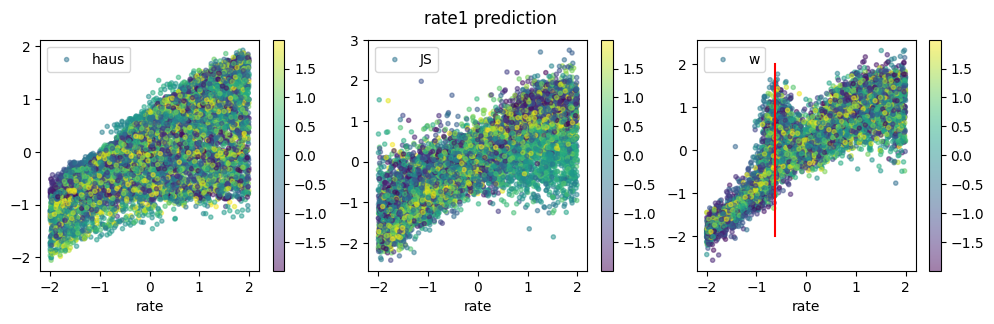

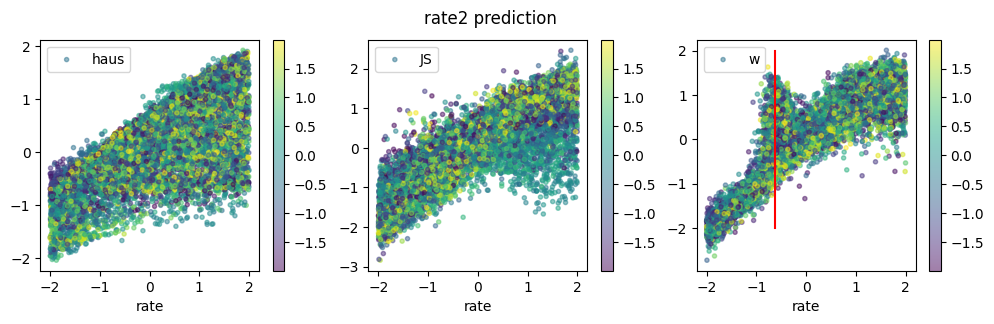

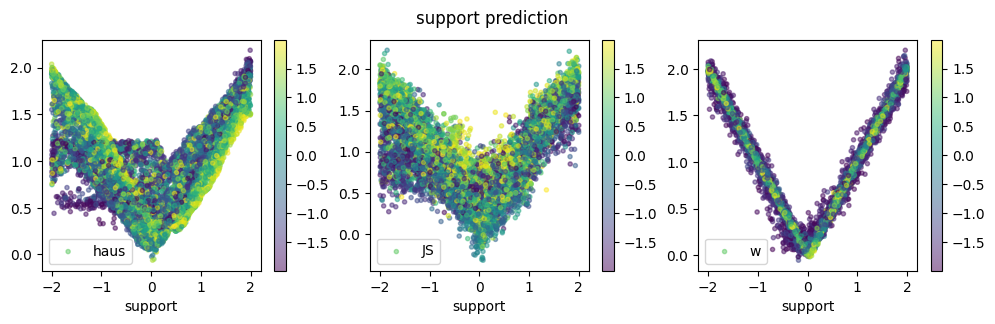

In [24]:
plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
idx=0
scatter = plt.scatter(y_test_np[:,idx], y_pred_haus[:,idx], c = y_test_np[:,2], marker='.', alpha=0.5, label='haus')
plt.legend()
plt.colorbar(scatter)
plt.xlabel('rate')

plt.subplot(1,3,2)
idx=0
scatter = plt.scatter(y_test_np[:,idx], y_pred_JS[:,idx], c = y_test_np[:,2], marker='.', alpha=0.5, label='JS')
plt.legend()
plt.colorbar(scatter)
plt.xlabel('rate')

plt.subplot(1,3,3)
idx=0
scatter = plt.scatter(y_test_np[:,idx], y_pred_w[:,idx], c = y_test_np[:,2], marker='.', alpha=0.5, label='w')
val=-0.625
plt.plot([val, val], [-2, 2], 'r')
plt.legend()
plt.colorbar(scatter)
plt.xlabel('rate')
plt.suptitle('rate1 prediction')

plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
idx=1
scatter = plt.scatter(y_test_np[:,idx], y_pred_haus[:,idx], c = y_test_np[:,2], marker='.', alpha=0.5, label='haus')
plt.legend()
plt.colorbar(scatter)
plt.xlabel('rate')

plt.subplot(1,3,2)
idx=1
scatter = plt.scatter(y_test_np[:,idx], y_pred_JS[:,idx], c = y_test_np[:,2], marker='.', alpha=0.5, label='JS')
plt.legend()
plt.colorbar(scatter)
plt.xlabel('rate')

plt.subplot(1,3,3)
idx=1
scatter = plt.scatter(y_test_np[:,idx], y_pred_w[:,idx], c = y_test_np[:,2], marker='.', alpha=0.5, label='w')
val=-0.625
plt.plot([val, val], [-2, 2], 'r')
plt.legend()
plt.colorbar(scatter)
plt.xlabel('rate')
plt.suptitle('rate2 prediction')

plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
idx=2
scatter = plt.scatter(y_test_np[:,idx], y_pred_haus[:,idx], c = y_test_np[:,0], marker='.', alpha=0.5, label='haus')
plt.legend()
plt.colorbar(scatter)
plt.xlabel('support')

plt.subplot(1,3,2)
idx=2
scatter = plt.scatter(y_test_np[:,idx], y_pred_JS[:,idx], c = y_test_np[:,0], marker='.', alpha=0.5, label='JS')
plt.legend()
plt.colorbar(scatter)
plt.xlabel('support')

plt.subplot(1,3,3)
idx=2
scatter = plt.scatter(y_test_np[:,idx], y_pred_w[:,idx], c = y_test_np[:,0], marker='.', alpha=0.5, label='w')
plt.legend()
plt.colorbar(scatter)
plt.xlabel('support')
plt.suptitle('support prediction')

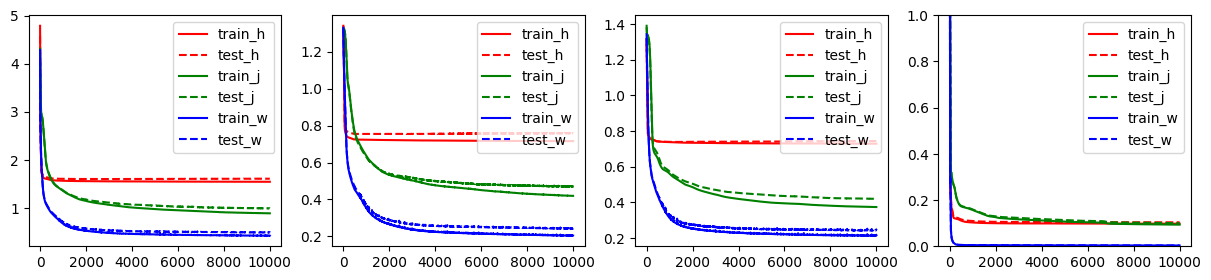

In [25]:
plt.figure(figsize=(15, 3))
plt.subplot(1,4,1)
plt.plot(loss_haus_traj.sum(axis=-1), 'r', label='train_h')
plt.plot(testloss_haus_traj.sum(axis=-1), 'r--', label='test_h')
plt.plot(loss_JS_traj.sum(axis=-1), 'g', label='train_j')
plt.plot(testloss_JS_traj.sum(axis=-1), 'g--', label='test_j')
plt.plot(loss_w_traj.sum(axis=-1), 'b', label='train_w')
plt.plot(testloss_w_traj.sum(axis=-1), 'b--', label='test_w')
# plt.ylim([0, 2])
plt.legend()

plt.subplot(1,4,2)
idx = 0
plt.plot(loss_haus_traj[:,idx], 'r', label='train_h')
plt.plot(testloss_haus_traj[:,idx], 'r--', label='test_h')
plt.plot(loss_JS_traj[:,idx], 'g', label='train_j')
plt.plot(testloss_JS_traj[:,idx], 'g--', label='test_j')
plt.plot(loss_w_traj[:,idx], 'b', label='train_w')
plt.plot(testloss_w_traj[:,idx], 'b--', label='test_w')
# plt.ylim([0, 1.2])
plt.legend()

plt.subplot(1,4,3)
idx = 1
plt.plot(loss_haus_traj[:,idx], 'r', label='train_h')
plt.plot(testloss_haus_traj[:,idx], 'r--', label='test_h')
plt.plot(loss_JS_traj[:,idx], 'g', label='train_j')
plt.plot(testloss_JS_traj[:,idx], 'g--', label='test_j')
plt.plot(loss_w_traj[:,idx], 'b', label='train_w')
plt.plot(testloss_w_traj[:,idx], 'b--', label='test_w')
# plt.ylim([0, 1])
plt.legend()

plt.subplot(1,4,4)
idx = 2
plt.plot(loss_haus_traj[:,idx], 'r', label='train_h')
plt.plot(testloss_haus_traj[:,idx], 'r--', label='test_h')
plt.plot(loss_JS_traj[:,idx], 'g', label='train_j')
plt.plot(testloss_JS_traj[:,idx], 'g--', label='test_j')
plt.plot(loss_w_traj[:,idx], 'b', label='train_w')
plt.plot(testloss_w_traj[:,idx], 'b--', label='test_w')
plt.ylim([0, 1])
plt.legend()

In [26]:
testloss_w_traj[-1], testloss_JS_traj[-1], testloss_haus_traj[-1]

(array([0.24360718, 0.24452339, 0.00369999], dtype=float32),
 array([0.4699177 , 0.41962534, 0.10027674], dtype=float32),
 array([0.75922793, 0.743474  , 0.10373656], dtype=float32))

In [28]:
import pickle
y_train_mean = y_train_np2.mean(axis=0)
y_test_mean = y_test_np2.mean(axis=0)
res = {}
res['test_const'] = ((y_test_np2 - y_train_mean)**2).mean(axis=0)
res['y_test_var'] = ((y_test_np2 - y_test_mean)**2).mean(axis=0)
res['testloss_w'] = testloss_w_traj
res['testloss_JS'] = testloss_JS_traj
res['testloss_haus'] = testloss_haus_traj

# filename = './synthetic_seed1.pickle'
# with open(filename, 'wb') as handle:
#     pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
y_train_mean, y_test_mean

(array([-0.00801426,  0.01822909,  1.00250423]),
 array([ 0.00690652, -0.00170315,  0.99878935]))

In [30]:
res['y_test_var']

array([1.33129183, 1.32485809, 0.33584177])